## **Connect and query a db with sqlite and explore it in the tidyverse**

## Explore 'Korlotta Chocolates and Wines' data with Rsqlite 
Data scientists/analysts primarly role is to explore and analyze data, producing reports and graphs. People who are familiar with SQL can employ sqlite to analyze large datasets, imported from CSV files, and then slice and dice the raw data by using SQL queries. Also, more complex analysis and data visualization can be performed using R language.

Let's imagine that we are a Swedish Italian Wine and Chocolate company that would like to start selling wine and chocolate packages. Before launching our products on the market, we wish to analyze competitors' data.

In [30]:
#Load packages required
library(DBI)
library(RSQLite)
library(tidyverse)

Let's start by creating a new temporary SQLite database, that will be automatically deleted when we disconnect from it. Then let's load the raw data from public csv files and store it as R tibbles. Lastly, let's copy the 2 R tibbles into our SQLite database.

In [31]:
#Creating temporary SQLite database
mydb <- dbConnect(RSQLite::SQLite(), "")

In [32]:
#Loading wine ratings and chocolate ratings data from csv into tibbles
wine_ratings <- readr::read_csv('https://raw.githubusercontent.com/paiml/wine-ratings/main/wine-ratings.csv')
chocolate_ratings <- readr::read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-18/chocolate.csv')


New names:
• `` -> `...1`
Rows: 32780 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): name, region, variety, notes
dbl (2): ...1, rating
lgl (1): grape

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2530 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): company_manufacturer, company_location, country_of_bean_origin, spe...
dbl (3): ref, review_date, rating

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [33]:
#Copying tibbles into SQL database
dbWriteTable(mydb, "chocolate_ratings", chocolate_ratings)
dbWriteTable(mydb, "wine_ratings", wine_ratings)
dbListTables(mydb)

[1] "chocolate_ratings" "wine_ratings"

First thing first, let's have a look to the data we are going to use for our analysis, by starting with the chocolate ratings dataset and let's print the first 5 rows.

In [34]:
#Querying the database to print first 5 rows
dbGetQuery(mydb, 'SELECT * FROM chocolate_ratings LIMIT 5')

ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
2546,5150,U.S.A.,2021,Venezuela,"Sur del Lago, batch 1",72%,"3- B,S,C","fatty, earthy, moss, nutty,chalky",3.00


One of the main issues when dealing with real-world data is having missing values. Let's look if we have Not Available (NA) values in our chocolate ratings dataset. 

In [35]:
#Checking if there are NA values
colSums(is.na(chocolate_ratings))

ref             company_manufacturer 
                               0                                0 
                company_location                      review_date 
                               0                                0 
          country_of_bean_origin specific_bean_origin_or_bar_name 
                               0                                0 
                   cocoa_percent                      ingredients 
                               0                               87 
  most_memorable_characteristics                           rating 
                               0                                0

Now, let's select only the columns which has no NA values and which will be useful for our analysis, by using the 'SELECT' operator.

In [36]:
#Querying the database to select a subset of columns
chocolate_ratings <- dbGetQuery(mydb, 'SELECT ref, company_manufacturer, company_location, country_of_bean_origin, most_memorable_characteristics, rating FROM chocolate_ratings')
chocolate_ratings

ref,company_manufacturer,company_location,country_of_bean_origin,most_memorable_characteristics,rating
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2454,5150,U.S.A.,Tanzania,"rich cocoa, fatty, bready",3.25
2458,5150,U.S.A.,Dominican Republic,"cocoa, vegetal, savory",3.50
2454,5150,U.S.A.,Madagascar,"cocoa, blackberry, full body",3.75
2542,5150,U.S.A.,Fiji,"chewy, off, rubbery",3.00
2546,5150,U.S.A.,Venezuela,"fatty, earthy, moss, nutty,chalky",3.00
2546,5150,U.S.A.,Uganda,"mildly bitter, basic cocoa, fatty",3.25
2542,5150,U.S.A.,India,"milk brownie, macadamia,chewy",3.50
797,A. Morin,France,Bolivia,"vegetal, nutty",3.50
797,A. Morin,France,Peru,"fruity, melon, roasty",3.75


Similarly we'll proceed for wine_ratings.

In [37]:
#Querying the database to print first 5 rows
dbGetQuery(mydb, 'SELECT * FROM wine_ratings LIMIT 5')

...1,name,grape,region,variety,rating,notes
<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>
0,1000 Stories Bourbon Barrel Aged Batch Blue Carignan 2016,NA,"Mendocino, California",Red Wine,91,"This is a very special, limited release of 1000 Stories Bourbon Barrel-Aged Carignan, their first-ever release of Carignan as a single varietal. Classic and rustic with a little edge. Look for notes of brilliantly racy red and black fruits set to a rich backdrop of toast, herbs, and cocoa."
1,1000 Stories Bourbon Barrel Aged Gold Rush Red 2016,NA,California,Red Wine,89,"The California Gold Rush was a period of courage, bravado and curiosity. It was with these characteristics in mind that we crafted Gold Rush Red. Grapes chosen from the golden hills and valleys of California were blended to create this bold, adventurous testament to that intrepid spirit."
2,1000 Stories Bourbon Barrel Aged Gold Rush Red 2017,NA,California,Red Wine,90,"The California Gold Rush was a period of courage, bravado and curiosity. Gold Rush is crafted with these characteristics in mind. The grapes used to blend this bold wine are carefully selected from golden hills and valleys of California. It is finished in bourbon barrels, which complements this rich wine with notes of charred vanilla and dried herbs."
3,1000 Stories Bourbon Barrel Aged Zinfandel 2013,NA,"North Coast, California",Red Wine,91,"The wine has a deep, rich purple color. An intense raspberry fruit is on the nose, with black pepper spice and a touch of cloves and dried herbs. The palate is full with ripe tannins, big black and red fruits, followed by an array of spices. The wine finishes with a touch of warmth that lingers on and on."
4,1000 Stories Bourbon Barrel Aged Zinfandel 2014,NA,California,Red Wine,90,"Batch #004 is the first release of the 2014 vintage and once againMendocino Zinfandel plays a big role in the blend with classic oldvineyards such as Sargentini and Rucker vineyards. Head trained and dry farmed, these vineyards give nice raspberry fruits. Dry Creek Valley Zinfandel also makes a big impact on the blend in Batch #004. Dry Creek is a classic and well known source for great Zinfandel and has added a new dimension to the 1000 Stories blend. Black fruits with distinct notes of black pepper and even a bit of clove spice add complexity to the blend. Also new to this batch is the addition of Lodi Zinfandel, with its iconic bold flavors and big character. Rounding out the blend are some Zinfandels from Colusa County, Syrah from Paso Robles and Petite sirah from Mendocino. A portion of the wine is aged in French and American oak for 6 months and then aged further in bourbon barrels. We’ve selected new and used bourbon barrels for these small batches of Zinfandel, which impart characteristics specific to these barrels: charred vanilla, dried herbs and a hint of caramel."


In [38]:
#Checking if there are NA values
colSums(is.na(wine_ratings))

...1    name   grape  region variety  rating   notes 
      0       0   32780       3     358       0     184

Again, let's SELECT the columns we wish to use for our analysis, by avoiding the ones with lots of missing values.

In [39]:
#Querying the database to select a subset of columns
wine_ratings <- dbGetQuery(mydb, 'SELECT name, region, rating, notes FROM wine_ratings')
wine_ratings

name,region,rating,notes
<chr>,<chr>,<dbl>,<chr>
1000 Stories Bourbon Barrel Aged Batch Blue Carignan 2016,"Mendocino, California",91,"This is a very special, limited release of 1000 Stories Bourbon Barrel-Aged Carignan, their first-ever release of Carignan as a single varietal. Classic and rustic with a little edge. Look for notes of brilliantly racy red and black fruits set to a rich backdrop of toast, herbs, and cocoa."
1000 Stories Bourbon Barrel Aged Gold Rush Red 2016,California,89,"The California Gold Rush was a period of courage, bravado and curiosity. It was with these characteristics in mind that we crafted Gold Rush Red. Grapes chosen from the golden hills and valleys of California were blended to create this bold, adventurous testament to that intrepid spirit."
1000 Stories Bourbon Barrel Aged Gold Rush Red 2017,California,90,"The California Gold Rush was a period of courage, bravado and curiosity. Gold Rush is crafted with these characteristics in mind. The grapes used to blend this bold wine are carefully selected from golden hills and valleys of California. It is finished in bourbon barrels, which complements this rich wine with notes of charred vanilla and dried herbs."
1000 Stories Bourbon Barrel Aged Zinfandel 2013,"North Coast, California",91,"The wine has a deep, rich purple color. An intense raspberry fruit is on the nose, with black pepper spice and a touch of cloves and dried herbs. The palate is full with ripe tannins, big black and red fruits, followed by an array of spices. The wine finishes with a touch of warmth that lingers on and on."
1000 Stories Bourbon Barrel Aged Zinfandel 2014,California,90,"Batch #004 is the first release of the 2014 vintage and once againMendocino Zinfandel plays a big role in the blend with classic oldvineyards such as Sargentini and Rucker vineyards. Head trained and dry farmed, these vineyards give nice raspberry fruits. Dry Creek Valley Zinfandel also makes a big impact on the blend in Batch #004. Dry Creek is a classic and well known source for great Zinfandel and has added a new dimension to the 1000 Stories blend. Black fruits with distinct notes of black pepper and even a bit of clove spice add complexity to the blend. Also new to this batch is the addition of Lodi Zinfandel, with its iconic bold flavors and big character. Rounding out the blend are some Zinfandels from Colusa County, Syrah from Paso Robles and Petite sirah from Mendocino. A portion of the wine is aged in French and American oak for 6 months and then aged further in bourbon barrels. We’ve selected new and used bourbon barrels for these small batches of Zinfandel, which impart characteristics specific to these barrels: charred vanilla, dried herbs and a hint of caramel."
1000 Stories Bourbon Barrel Aged Zinfandel 2016,California,91,"1,000 Stories Bourbon barrel-aged Zinfandel is a harmonious balance of Zinfandel grapes from Mendocino and Sonoma counties which are bursting with aromatic red fruit scents and complex black fruit flavors. A touch of Petite Sirah and Syrah enhance those flavors even more with bold black and white pepper spices. The batch is then rounded out with a layer of smokiness derived from the new bourbon barrel aging."
1000 Stories Bourbon Barrel Aged Zinfandel 2017,California,92,"Batch 55 embodies an opulent vintage, which saw its fruit grow amid lush rainfall and balmy temperatures. Nuanced aromas of sun-baked raspberry, crushed blueberry, freshly-turned earth and hints of nutmeg swirl in the glass, segueing to a palate of jammy blackberries, clove and caramel. This blend showcases Zinfandel’s warm, luscious character, accentuated by time spent in our charred bourbon barrels, which lent a graceful, smoky finish to the wine."
12 Linajes Crianza 2014,"Ribera del Duero, Spain",92,"Red with violet hues. The aromas are very intense with mineral and dairy notes with essence of wild black fruits (raspberries and blackberries) combined with spicy elegant notes of black pepper and cloves 

## What are the best wines?

Let's explore which are the top 5 wines with the best ratings, by querying the database using the ORDER BY statement. Then let's plot these quantities as a bar chart, by using ggplot2.

In [40]:
wine_ratings <- dbGetQuery(mydb, 'SELECT name, region, AVG(rating) AS rating, notes FROM wine_ratings GROUP BY name ORDER BY rating DESC LIMIT 5')
wine_ratings

name,region,rating,notes
<chr>,<chr>,<dbl>,<chr>
Larkmead Solari Cabernet Sauvignon 2014,"Napa Valley, California",99,"There is uniqueness to Solari that cannot be found anywhere else on the Larkmead estate. The bouquet is almost dense,and builds with each swirl of the glass. From blackberry jamto purple flowers, the aromas swell slowly, drawing you inwith their momentum."
Larkmead Solari Cabernet Sauvignon 2005,"Napa Valley, California",99,"Deep ruby/purple color. Powerfully intense aromas of blackberry,sweet mint and sage rounded out by dusty cocoa and the vineyard’s signature profile of wet rocks/gravel. Rich black fruits dominate the palate with cassis and blackberry leading to a textured, voluptuous mid palate and then rich, broad envelopingtannins. The wine finishes long with a burst of dark cherry sweetness."
Larkmead Solari Cabernet Sauvignon (1.5 Liter Magnum) 2005,"Napa Valley, California",99,"Deep ruby/purple color. Powerfully intense aromas of blackberry,sweet mint and sage rounded out by dusty cocoa and the vineyard’s signature profile of wet rocks/gravel. Rich black fruits dominate the palate with cassis and blackberry leading to a textured, voluptuous mid palate and then rich, broad envelopingtannins. The wine finishes long with a burst of dark cherry sweetness."
Lail J. Daniel Cuvee Cabernet Sauvignon 2013,"Napa Valley, California",99,"The 2013 growing season could be the equal of (or even superior to) the 2012, considered by many as a perfect season. This J. Daniel Cuvée is 100% Cabernet Sauvignon, showing off the power and purity of the vintage. Dense, extracted and intense, it has aromas and flavors of blackberry, boysenberry, crème de cassis, and dark chocolate. This may be the greatest J. Daniel Cuvée ever made, truly one for the ages."
Lail J. Daniel Cuvee Cabernet Sauvignon (1.5 Liter Magnum) 2013,"Napa Valley, California",99,"The 2013 growing season could be the equal of (or even superior to) the 2012, considered by many as a perfect season. This J. Daniel Cuvée is 100% Cabernet Sauvignon, showing off the power and purity of the vintage. Dense, extracted and intense, it has aromas and flavors of blackberry, boysenberry, crème de cassis, and dark chocolate. This may be the greatest J. Daniel Cuvée ever made, truly one for the ages."


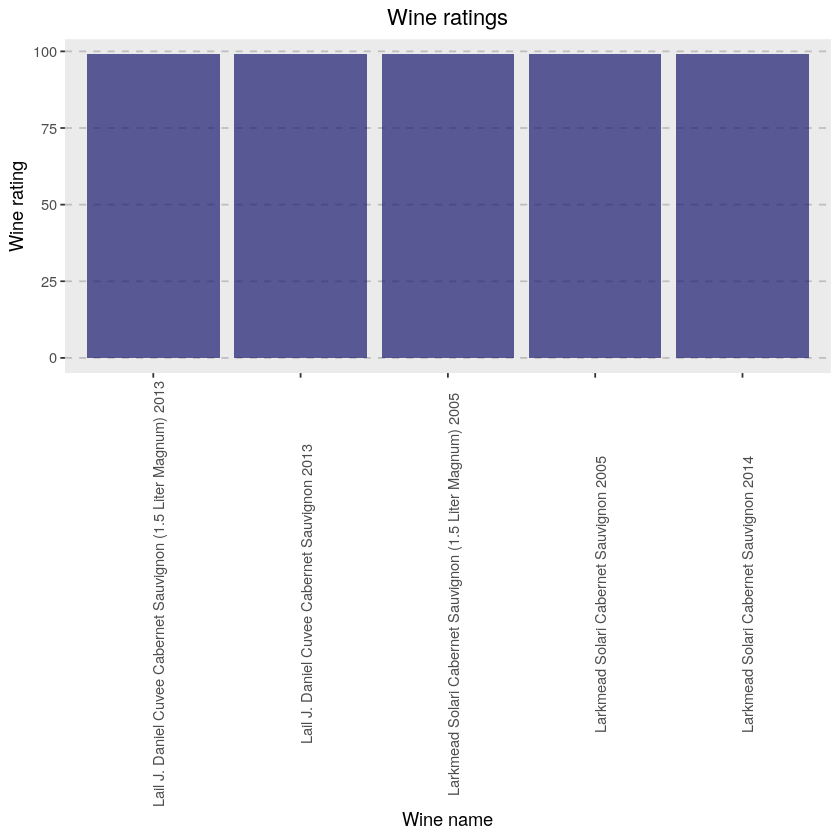

In [41]:
#Plotting ratings of 5 top wines as a bar chart
wine_ratings %>% 
  ggplot() +
  geom_col(mapping = aes(x = name, y = rating),
           fill = "midnightblue", alpha = 0.7) +
  ggtitle("Wine ratings") +
  xlab("Wine name") +
  ylab("Wine rating") +
  theme(
    plot.title = element_text(hjust = 0.5),
    
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = "gray", linetype = "dashed", size = 0.5),
    
    axis.text.x = element_text(angle = 90)
    
  )

Now that we identified the 5 top best rated wines in the dataset, having all the same ratings, it would be interesting to explore the distribution of ratings across the dataset. This can be achieved by plotting an histogram.

In [42]:
# Load statip into the current R sesssion
library(statip)

wine_ratings <- dbGetQuery(mydb, 'SELECT name, region, rating, notes FROM wine_ratings')

# Get summary statistics
min_val <- min(wine_ratings$rating)
max_val <- max(wine_ratings$rating)
mean_val <- mean(wine_ratings$rating)
med_val <- median(wine_ratings$rating)
mod_val <- mfv(wine_ratings$rating)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)

Minimum:  85 
Mean:  91.19 
Median:  91 
Mode:  90 
Maximum:  99

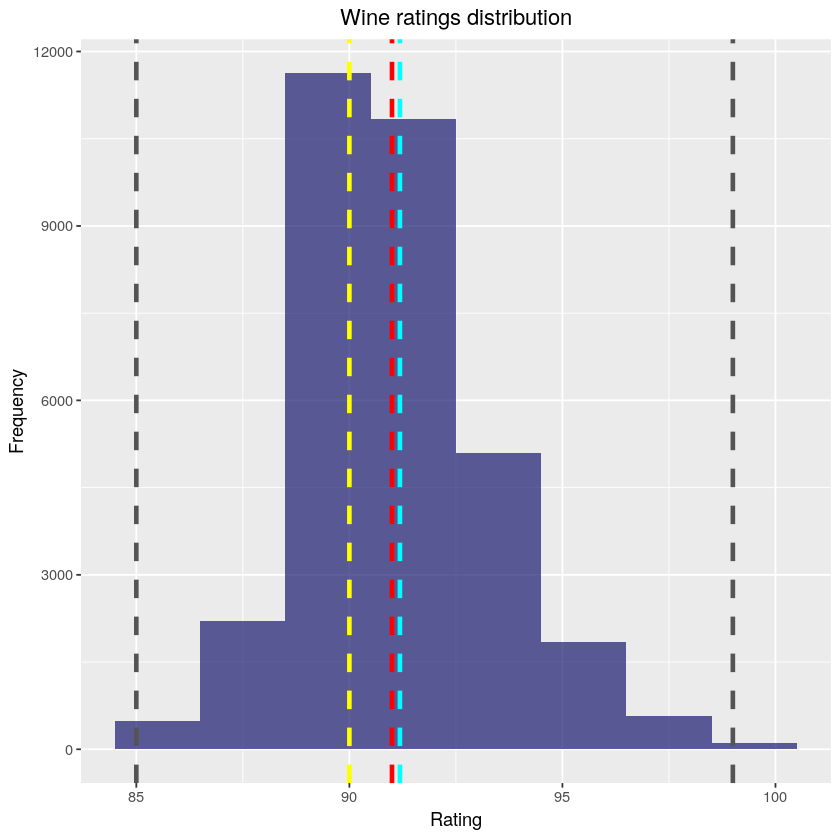

In [43]:
# Plotting the distribution of the wines ratings as an histogram
ggplot(data = wine_ratings) +
    geom_histogram(mapping = aes(x = rating), , binwidth = 2, boundary = 0.5, fill = "midnightblue", alpha = 0.7) +
    # Add lines for the statistics
    geom_vline(xintercept = min_val, color = 'gray33', linetype = "dashed", size = 1.3) +
    geom_vline(xintercept = mean_val, color = 'cyan', linetype = "dashed", size = 1.3) +
    geom_vline(xintercept = med_val, color = 'red', linetype = "dashed", size = 1.3 ) +
    geom_vline(xintercept = mod_val, color = 'yellow', linetype = "dashed", size = 1.3 ) +
    geom_vline(xintercept = max_val, color = 'gray33', linetype = "dashed", size = 1.3 ) +
    xlab('Rating') +
    ylab('Frequency') +
    ggtitle("Wine ratings distribution") +
    theme(plot.title = element_text(hjust = 0.5))

Another way to explore data distribution is visualizing it as a box plot.

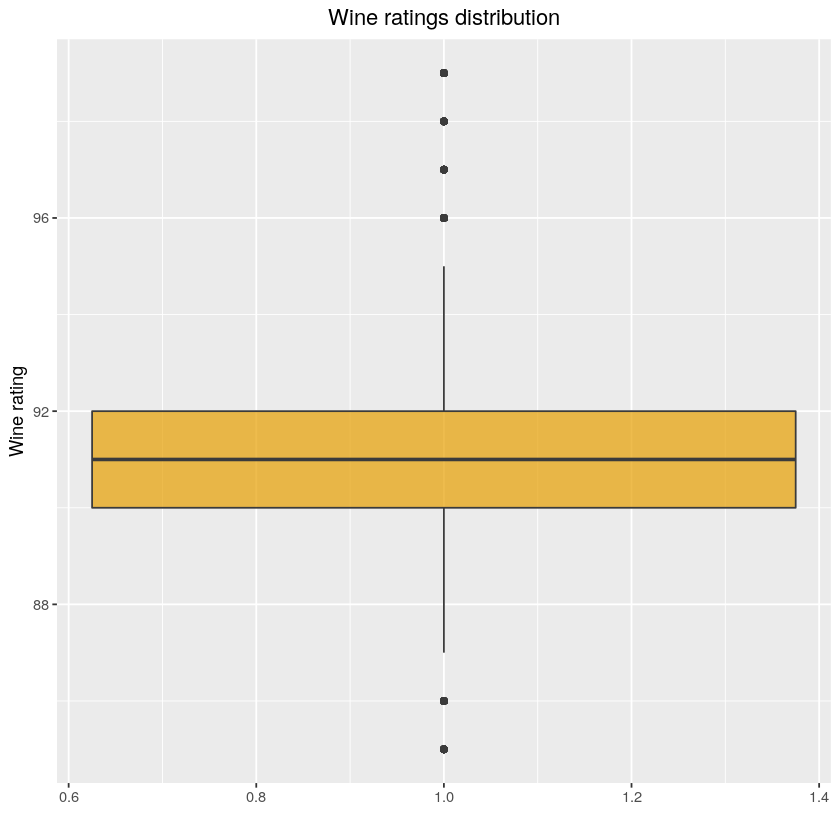

In [44]:
# Plot a box plot
ggplot(data = wine_ratings) +
  geom_boxplot(mapping = aes(x = 1, y = rating), fill = "#E69F00", color = "gray23", alpha = 0.7) +
  
  # Add titles and labels
  ggtitle("Wine ratings distribution") +
  xlab("") +
  ylab("Wine rating") +
  theme(plot.title = element_text(hjust = 0.5))

## What are the chocolates from Italy?
Let's move our analysis to chocolates and, in particular, let's explore companies' locations. To answer to the question above we can rely on the WHERE statement.

In [45]:
# Querying db to get only chocolate ratings from Italy
dbGetQuery(mydb, 'SELECT distinct ref, company_manufacturer, company_location, country_of_bean_origin FROM chocolate_ratings WHERE company_location == "Italy"')

ref,company_manufacturer,company_location,country_of_bean_origin
<dbl>,<chr>,<chr>,<chr>
75,Amedei,Italy,Blend
123,Amedei,Italy,Ecuador
123,Amedei,Italy,Jamaica
123,Amedei,Italy,Grenada
129,Amedei,Italy,Trinidad
170,Amedei,Italy,Blend
123,Amedei,Italy,Venezuela
979,Amedei,Italy,Peru
2088,Amedei,Italy,Madagascar


This is quite easy right? Now let's do a step forward and let's look how this slice of data is part of a whole. This means visualize proportions, by using pie charts.

In [46]:
# Counting n chocolate records per country
n_chocolates_per_country <- chocolate_ratings %>% 
       distinct(ref, company_manufacturer, company_location, country_of_bean_origin) %>%
       group_by(company_location) %>% 
       count()
           
#Computing tot chocolates items and total of chocolates with less than 35 records           
tot_chocolates <- chocolate_ratings %>%
                  distinct(ref, company_manufacturer, company_location, country_of_bean_origin) %>% 
                  nrow()
                  
difference <- n_chocolates_per_country %>% 
              filter(n < 35) %>% 
              pull(n) %>% sum()

tot_chocolates
difference

[1] 2271

[1] 452

In [47]:
#Filtering for n chocolates > 35
n_chocolates_per_country <-   
       n_chocolates_per_country %>% 
       filter (n > 35)

#Adding one record for 'Others'
n_chocolates_per_country <- 
       rbind(n_chocolates_per_country, tibble(
              company_location = c("Others"),
              n = difference
       ))

n_chocolates_per_country


company_location,n
<chr>,<int>
Australia,53
Belgium,62
Canada,160
Ecuador,38
France,167
Germany,37
Italy,73
U.K.,126
U.S.A.,1068


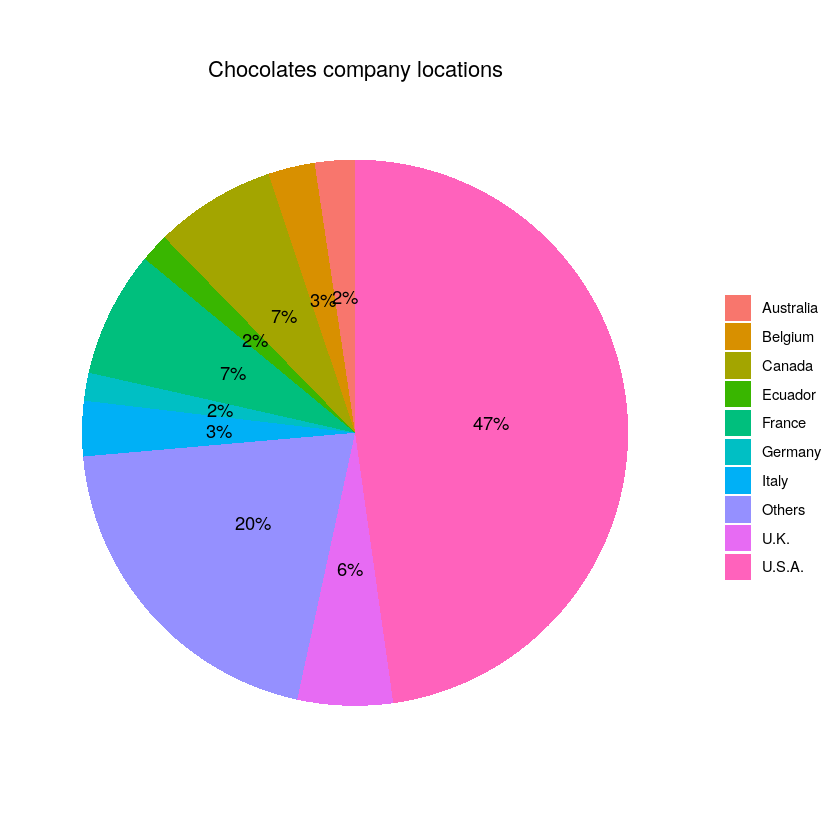

In [48]:
# Plotting a pie chart of chocolates company locations
ggplot(n_chocolates_per_country, aes(x="", y=n, fill=company_location)) +
  geom_bar(stat="identity", width=1) +
  coord_polar("y", start=0) +
  geom_text(aes(label = paste0(round(n*100/tot_chocolates), "%")), position = position_stack(vjust=0.5)) +
  labs(x = NULL, y = NULL, fill = NULL) +
  ggtitle("Chocolates company locations") +
  theme_classic() +
  theme(axis.line = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          plot.title = element_text(hjust = 0.5))

## Exploring spicy wines and chocolate combinations
We learnt how to visualize quantities, how to visualize data distributions and proportions. Now let's explore wines and chocolates pairings with similar taste ("spicy"). In particular, let's select all the spicy chocolates and wines and let's join them based on their region.

In [49]:
# Querying db to select all wines and chocolates that have spicy tastes and joining them on location
spicy_combinations <- dbGetQuery(mydb, 'SELECT ref AS chocolate_ref, company_location, most_memorable_characteristics, chocolate_ratings.rating AS chocolate_rating, name AS wine_name, region, wine_ratings.rating AS wine_rating, notes FROM 
                                        chocolate_ratings INNER JOIN wine_ratings on company_location = region
                                        WHERE most_memorable_characteristics LIKE "%spicy%" and notes LIKE "%spicy%"
                                        ORDER BY chocolate_rating desc, wine_rating desc')
                                        


As last step of this exploratory data analysis we wish to test the following hypothesis: "The regions that have the highest ratings for spicy wines also have high ratings for spicy chocolate". To check that, let's calculate the average rating for chocolate and wines, grouping by region. 

In [50]:
#Computing avg chocolate rating and avg wine rating for each region
library(scales)
spicy_combinations <- spicy_combinations %>%
    group_by(region) %>% 
    summarise(avg_chocolate_rating = mean(chocolate_rating), avg_wine_rating = mean(wine_rating)) %>%
    mutate(region = fct_reorder(region, avg_chocolate_rating, .desc = TRUE)) %>% 
    mutate(avg_chocolate_rating = rescale(avg_chocolate_rating, to = c(0, 10), from = c(0,5)))%>%
    mutate(avg_wine_rating = rescale(avg_wine_rating, to = c(0, 10), from = c(0,100)))%>%
    pivot_longer(!region, names_to = "Ratings", values_to = "Values") 
    

    spicy_combinations

region,Ratings,Values
<fct>,<chr>,<dbl>
Argentina,avg_chocolate_rating,7.000000
Argentina,avg_wine_rating,9.003846
Australia,avg_chocolate_rating,7.000000
Australia,avg_wine_rating,8.913043
Austria,avg_chocolate_rating,7.000000
Austria,avg_wine_rating,8.966667
Canada,avg_chocolate_rating,6.818182
Canada,avg_wine_rating,9.100000
France,avg_chocolate_rating,7.111111


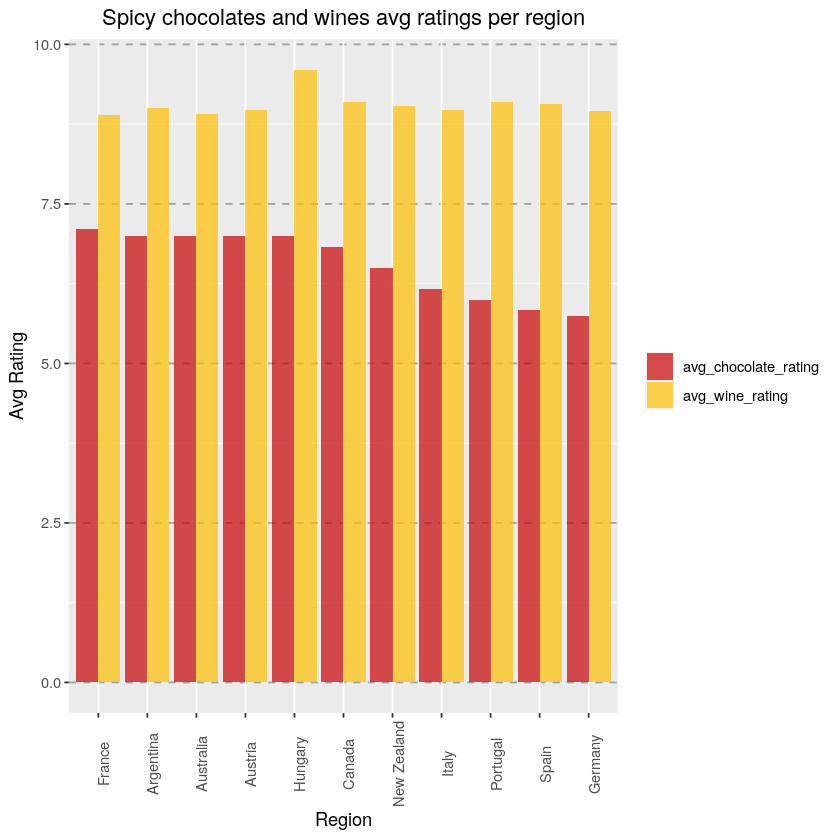

In [51]:
#Plotting bar plots with desc avg ratings for wines and chocolates
library(paletteer)

ggplot(data = spicy_combinations) +
  geom_bar(mapping = aes(x = region, y = Values, fill = Ratings), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Region') +
  ylab('Avg Rating') +
  ggtitle("Spicy chocolates and wines avg ratings per region") +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 90),
    legend.title = element_blank(),
    plot.title = element_text(hjust = 0.5)
    )

In [52]:
#Disconnecting from db
dbDisconnect(mydb)